# I. Importing the required libraries

In [115]:
## Python
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

import sklearn


# % pylab inline

# II. Importing datasets & Labels

In [2]:
# Data Directory
# Please edit according to your directory change.
Ravdess_paths= np.array(("E:/NYU_Classes/Project/Ravdess_Audio_Speech_Actors_01-24/","E:/NYU_Classes/Project/Ravdess_Audio_Song_Actors_01-24/"))
dir_list = os.listdir(Ravdess_paths[0])
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [4]:
# Create DataFrame for Data intel
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0
for data_path in Ravdess_paths:
    dir_list = os.listdir(data_path)
    dir_list.sort()
    for i in dir_list:
        file_list = os.listdir(data_path + i)
        for f in file_list:
            nm = f.split('.')[0].split('-')
            path = data_path + i + '/' + f
            src = int(nm[1])
            actor = int(nm[-1])
            emotion = int(nm[2])
            source = "Ravdess"

            if int(actor)%2 == 0:
                gender = "female"
            else:
                gender = "male"

            if nm[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if nm[4] == '01':
                statement = 0
            else:
                statement = 1

            if nm[5] == '01':
                repeat = 0
            else:
                repeat = 1

            if emotion == 1:
                lb = "neutral"
            elif emotion == 2:
                lb = "calm"
            elif emotion == 3:
                lb = "happy"
            elif emotion == 4:
                lb = "sad"
            elif emotion == 5:
                lb = "angry"
            elif emotion == 6:
                lb = "fearful"
            elif emotion == 7:
                lb = "disgust"
            elif emotion == 8:
                lb = "surprised"
            else:
                lb = "none"

            ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
            count += 1

In [10]:
print (len(ravdess_db))

2452


In [11]:
ravdess_db.sort_values(by='path',inplace=True)
ravdess_db.index =  range(len(ravdess_db.index))
ravdess_db.head()

,path,source,actor,gender,emotion,emotion_lb
0,E:/NYU_Classes/Project/Ravdess_Audio_Song_Acto...,Ravdess,1,male,1,neutral
1,E:/NYU_Classes/Project/Ravdess_Audio_Song_Acto...,Ravdess,1,male,1,neutral
2,E:/NYU_Classes/Project/Ravdess_Audio_Song_Acto...,Ravdess,1,male,1,neutral
3,E:/NYU_Classes/Project/Ravdess_Audio_Song_Acto...,Ravdess,1,male,1,neutral
4,E:/NYU_Classes/Project/Ravdess_Audio_Song_Acto...,Ravdess,1,male,2,calm


# III. Plotting the audio file's waveform and its spectrogram

In [13]:
# Load the audio with sampling rate(sr) = 44100 ( which is the standard sr for high quality audio)
sampling_rate = 44100

In [15]:
filename = ravdess_db.path[0]
print (filename)

E:/NYU_Classes/Project/Ravdess_Audio_Song_Actors_01-24/Actor_01/03-02-01-01-01-01-01.wav


In [44]:
samples, sample_rate = librosa.load(filename, res_type='kaiser_fast',sr=sampling_rate)
sample_rate, samples.shape


(44100, (186878,))

In [45]:
ipd.Audio(samples,rate=sample_rate)

#### Spectogram 

Spectogram is a visual representation of the bands of spectrum of frequencies of sound or other signals as they vary with time. 

In [26]:
def log_specgram(audio, sample_rate, window_size=20,step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Text(0.5, 0, 'Seconds')

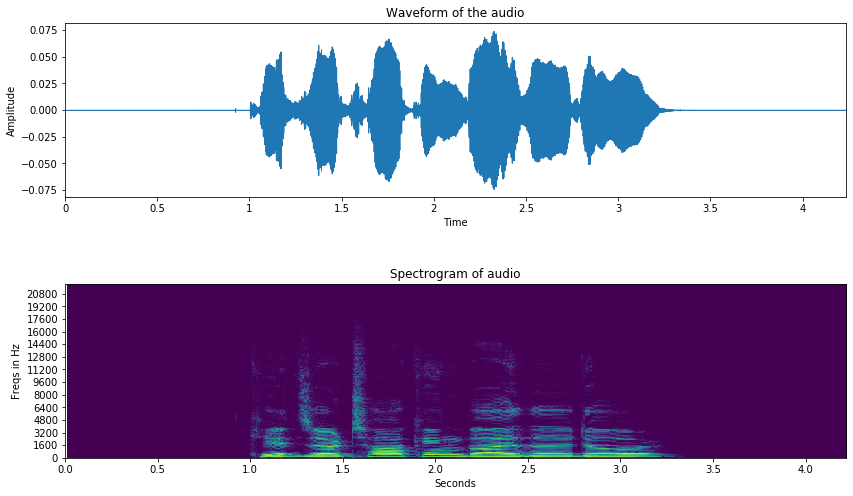

In [69]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)
fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## Trim the Audio 

Audio is trimmed to remove silence and white noise using the librosa package. The top_db, the threshold (in decibels) below reference to consider as silence, is set to 25db. Multiple values were tested to ensure there was no loss of audio.

In [64]:
samples_trim, index = librosa.effects.trim(samples,top_db=25)
samples_trim.shape, index

((96256,), array([ 46080, 142336]))

In [65]:
ipd.Audio(samples_trim,rate=sample_rate)

In [66]:
Difference_in_length = len(samples)-len(samples_trim)
Difference_in_length

90622

In [67]:
Difference_in_duration = librosa.get_duration(samples)-librosa.get_duration(samples_trim)
Difference_in_duration

4.10984126984127

Text(0.5, 0, 'Seconds')

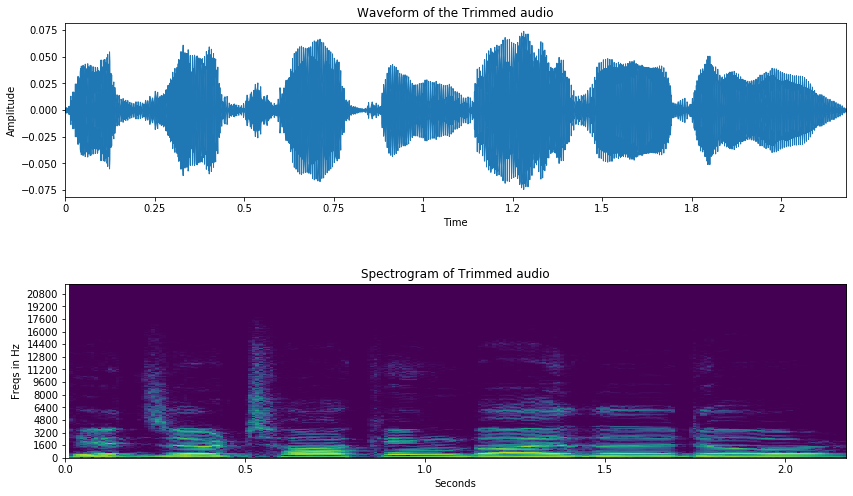

In [70]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples_trim, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Trimmed audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples_trim, sr=sample_rate)
fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of Trimmed audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

###### Inference:

We observe that without the loss of the any information from the audio, we have trimmed the audio to contain only relevant information for our analysis. However, we observe noise in the audio. Hence, we need to apply some signal processing techniques to remove unnecessary information within the audio segments.


### Wiener Filter to remove Noise

Wiener filter is a filter used to produce an estimate of a desired or target random process by linear time-invariant (LTI) filtering of an observed noisy process, assuming known stationary signal and noise spectra, and additive noise. The Wiener filter minimizes the mean square error between the estimated random process and the desired process.

In [72]:
sample_weiner = scipy.signal.wiener(samples_trim)
len(sample_weiner)

96256

In [73]:
ipd.Audio(sample_weiner,rate=sample_rate)

In [74]:
Diff_noise = sample_weiner-samples_trim
ipd.Audio(Diff_noise,rate=sample_rate)

Text(0.5, 0, 'Seconds')

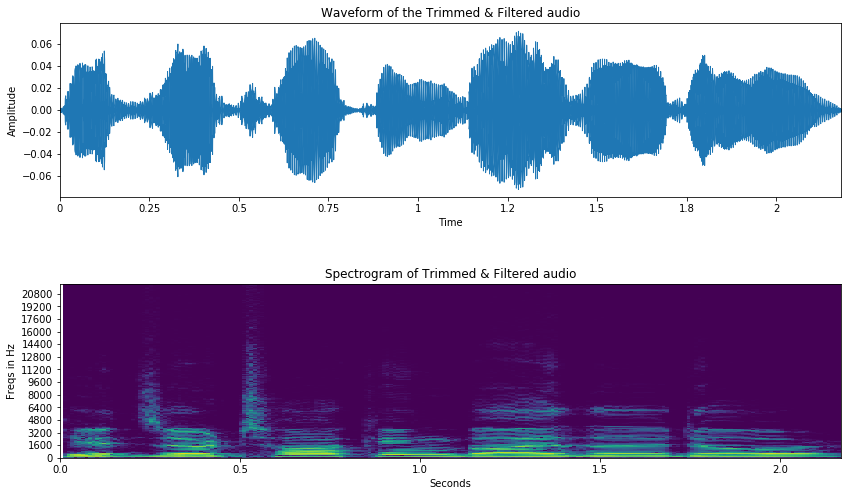

In [76]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(sample_weiner, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Trimmed & Filtered audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(sample_weiner, sr=sample_rate)
fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of Trimmed & Filtered audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

###### Waveform of the noise in the audio

Text(0.5, 0, 'Seconds')

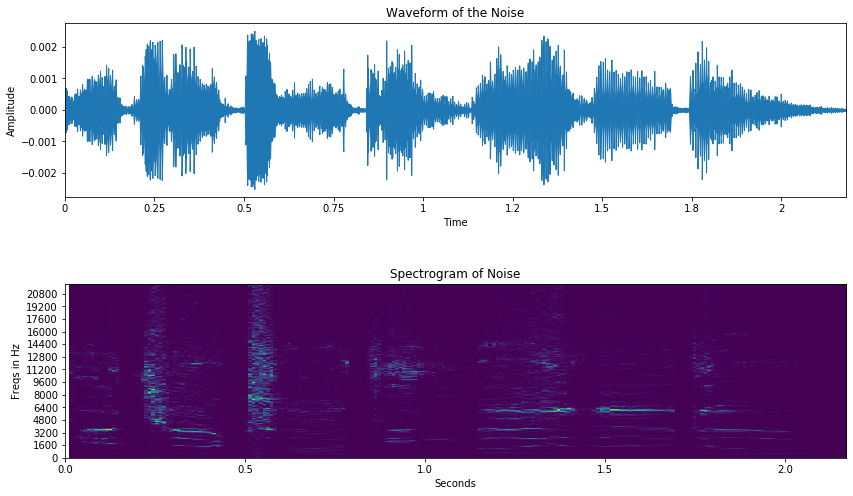

In [78]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(Diff_noise, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Noise')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(Diff_noise, sr=sample_rate)
fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of Noise')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

###### Inference:

From the above plots, we observe that by applying wiener filter, we have removed unnecessary noise in the data and we have a clear audio to extract additional information from it. 


## Feature Extraction 

Audio signals contain many features which could potentially help us in distinguishing the emotion. We need to extract characteristics that are relevant for emotion recognition. Features can be distinguished into Time-based features and frequence based features. 

### Time Based Features

#### 1. Zero Crossing Rate

The zero-crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to zero to negative or from negative to zero to positive.

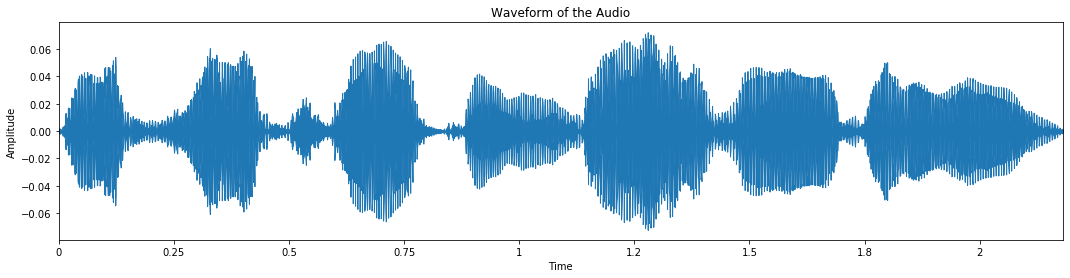

In [149]:
# Plotting Wave Form and Spectrogram
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(sample_weiner, sr=sample_rate)
fig.subplots_adjust(hspace=.5)


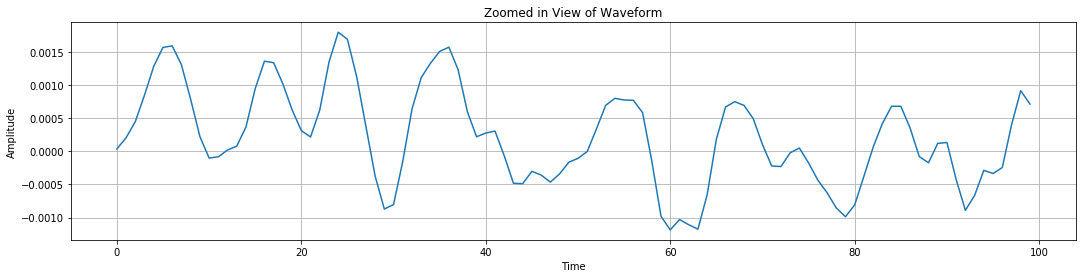

In [102]:
plt.figure(figsize=(18, 4))
plt.plot(sample_weiner[0:100])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Zoomed in View of Waveform")
plt.grid()


In [103]:
zero_crossings = librosa.zero_crossings(sample_weiner[0:100], pad=False)
print(sum(zero_crossings))


16


In [111]:
zero_crossings = librosa.zero_crossings(sample_weiner, pad=False)
print(sum(zero_crossings))

3288


#### 2. Spectral Centroid

The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. It is calculated as the weighted mean of the frequencies present in the signal, determined using a Fourier transform, with their magnitudes as the weights.

In [153]:
spectral_centroids = librosa.feature.spectral_centroid(sample_weiner, sr=sample_rate)[0]
spectral_centroids.shape

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
sc= sklearn.preprocessing.minmax_scale(spectral_centroids,axis=0)


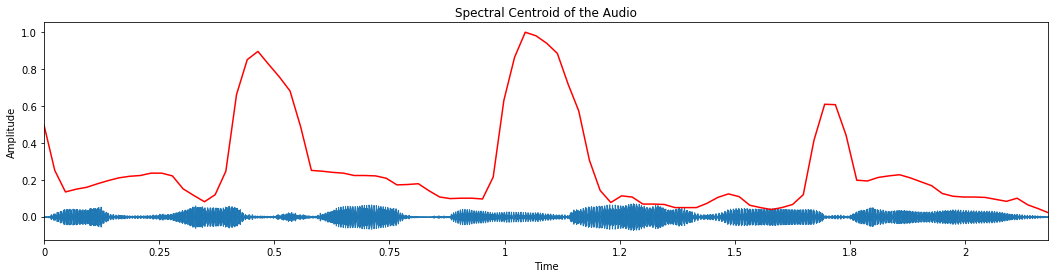

In [158]:
# Plotting Wave Form and Spectrogram
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Spectral Centroid of the Audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(sample_weiner, sr=sample_rate)
plt.plot(t,sc, color='r')
fig.subplots_adjust(hspace=.5)


#### 3. Spectral Roll-Off

Spectral rolloff is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

librosa.feature.spectral_rolloff computes the rolloff frequency for each frame in a signal:

In [173]:
spectral_rolloff = librosa.feature.spectral_rolloff(sample_weiner, sr=sample_rate)[0]
#spectral_centroids.shape

# Computing the time variable for visualization
frames = range(len(spectral_rolloff))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
sc= sklearn.preprocessing.minmax_scale(spectral_rolloff,axis=0)


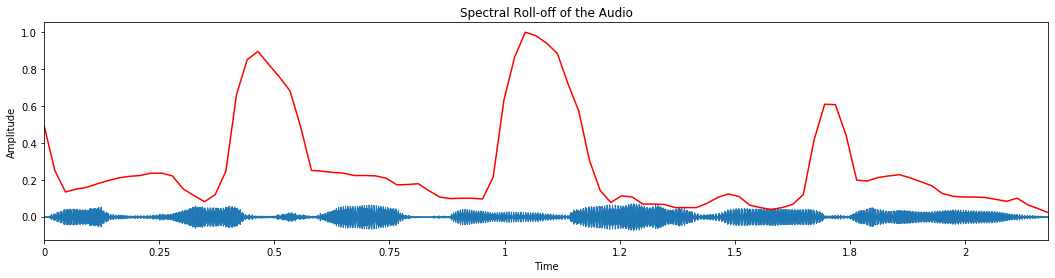

In [174]:
# Plotting Wave Form and Spectrogram
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Spectral Roll-off of the Audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(sample_weiner, sr=sample_rate)
plt.plot(t,sc, color='r')
fig.subplots_adjust(hspace=.5)


#### 4. RMSE

The energy of a signal corresponds to the total magntiude of the signal. For audio signals, that roughly corresponds to how loud the signal is. The root-mean-square energy (RMSE) is the square root of the mean of the energy.


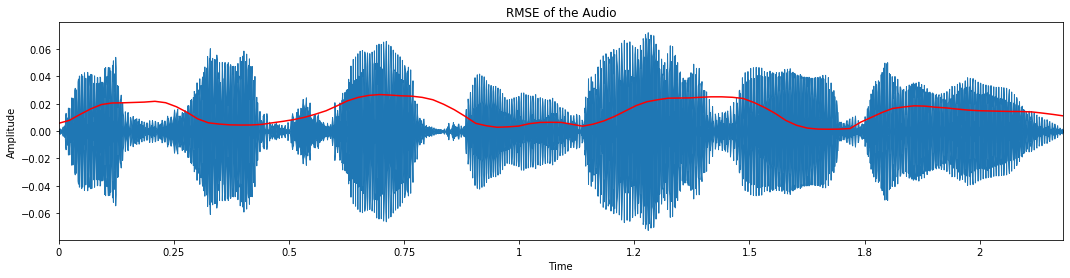

In [176]:
rmse = librosa.feature.rmse(sample_weiner)[0]
#rmse = sklearn.preprocessing.minmax_scale(rmse,axis=0)

# Plotting Wave Form and Spectrogram
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('RMSE of the Audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(sample_weiner, sr=sample_rate)
plt.plot(t,rmse, color='r')
fig.subplots_adjust(hspace=.5)



#### 5. Spectral Bandwidth ( Incomplete)

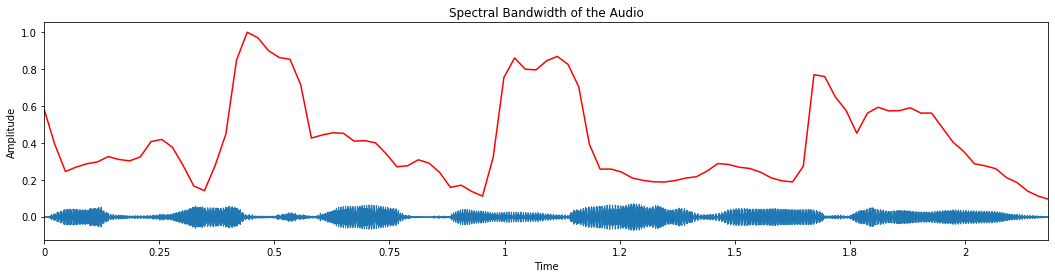

In [185]:
spec_bw = librosa.feature.spectral_bandwidth(y=sample_weiner, sr=sample_rate)[0]
spec_bw = sklearn.preprocessing.minmax_scale(spec_bw,axis=0)

# Plotting Wave Form and Spectrogram
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Spectral Bandwidth of the Audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(sample_weiner, sr=sample_rate)
plt.plot(t,spec_bw, color='r')
fig.subplots_adjust(hspace=.5)



### Frequency-based features

#### Mel Power Spectrogram

The mel-frequency spectogram is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

A time by frequency representation of the audio wave form is called a spectogram. That spectogram is then mapped to the Mel-scales thus giving us the Mel-spectogram. But because human perception of sound intensity is logarithmic in nature, the log form of the Mel-spectogram is the better one in theory.

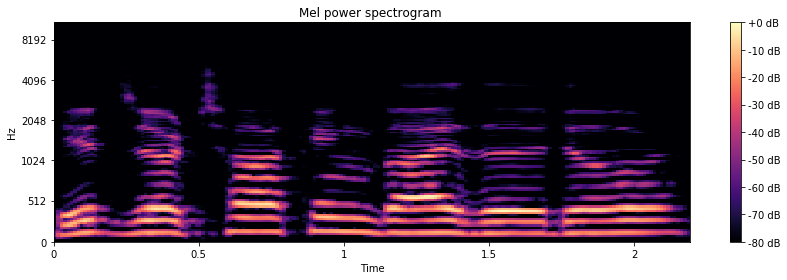

In [79]:
# Plotting Mel Power Spectrogram
S_sample = librosa.feature.melspectrogram(sample_weiner, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S_sample = librosa.amplitude_to_db(S_sample, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S_sample, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

#### Mel-frequency cepstral coefficients (MFCCs)

Mel-frequency cepstral coefficients (MFCCs) are coefficients that are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). In Mel-scale the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. 

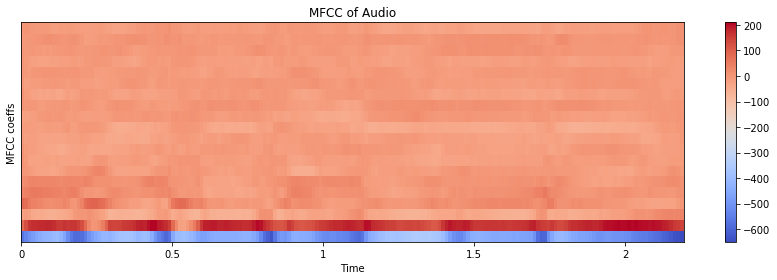

In [80]:
mfccs = librosa.feature.mfcc(sample_weiner, sr=sample_rate)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC of Audio')
plt.colorbar()
plt.tight_layout()

#### Delta MFCCS

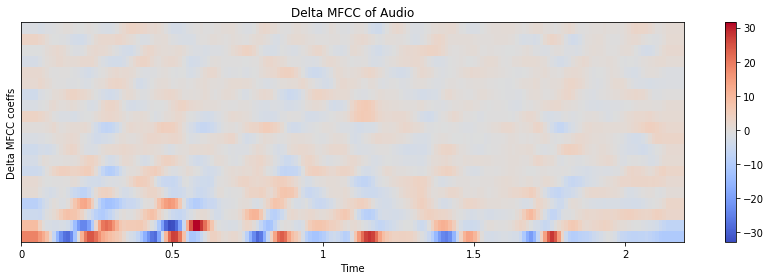

In [81]:
plt.figure(figsize=(12, 4))
delta_MFCCS =  librosa.feature.delta(mfccs,order=1)
librosa.display.specshow(delta_MFCCS, sr=sample_rate, x_axis='time')
plt.ylabel('Delta MFCC coeffs')
plt.xlabel('Time')
plt.title('Delta MFCC of Audio')
plt.colorbar()
plt.tight_layout()

#### Delta Delta MFCCs

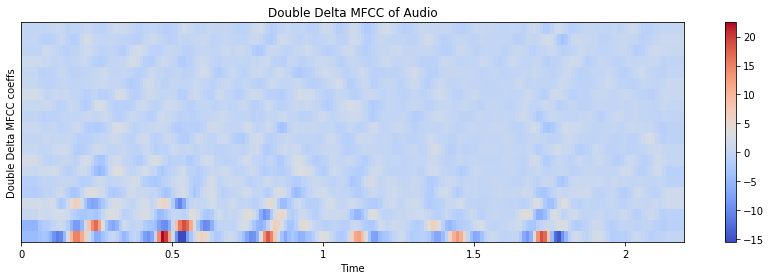

In [82]:
plt.figure(figsize=(12, 4))
d_delta_MFCCS =  librosa.feature.delta(mfccs,order=2)
librosa.display.specshow(d_delta_MFCCS, sr=sample_rate, x_axis='time')
plt.ylabel('Double Delta MFCC coeffs')
plt.xlabel('Time')
plt.title('Double Delta MFCC of Audio')
plt.colorbar()
plt.tight_layout()

#### Chroma Features 

Chroma features are representation for audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave. Since RAVDESS dataset also has songs, we use Chroma Features as well.

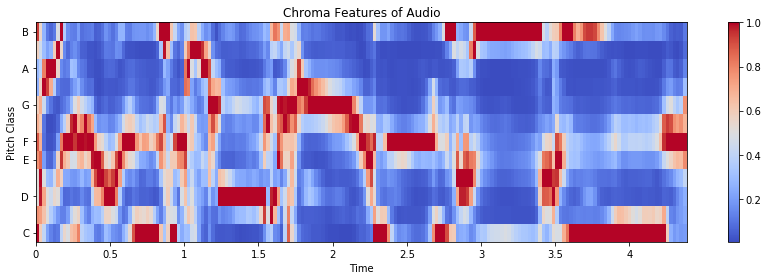

In [165]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(sample_weiner, sr=sample_rate, hop_length=hop_length)
plt.figure(figsize=(12, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length,cmap='coolwarm')
plt.ylabel('Pitch Class')
plt.xlabel('Time')
plt.title('Chroma Features of Audio')
plt.colorbar()
plt.tight_layout()
#librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

#### Inference: 

Given that an audio can be analysed using multiple features, we need to study each feature in depth to understand its characteristics for different emotions and gender.